# Estimation des paramètres

In [1]:
import utilities
import pandas            as pd
import numpy             as np
import seaborn           as sns
import matplotlib.pyplot as plt
import spacy
import re
import sklearn
import random
import textdistance

from spacy.vocab               import Vocab
from spacy.language            import Language
from spacy.tokens              import Token
from spacymoji                 import Emoji
from   sklearn.tree            import DecisionTreeClassifier
from   sklearn.model_selection import train_test_split
from sklearn                   import metrics


In [2]:
nlp = spacy.load("en_core_web_sm")

@Language.component("hashtag")
def hashtag_pipe(
    doc: spacy.tokens.Doc
) -> spacy.tokens.Doc:
    """
    A spaCy pipeline component that merges tokens of the form #word into a single token.

    Parameters
    ----------
    doc : spacy.tokens.Doc
        The input spaCy Doc object to process.

    Returns
    -------
    spacy.tokens.Doc
        The processed spaCy Doc object with hashtags merged into a single token.
    """
    len_doc = -1
    for token in doc:
        len_doc=len_doc+1
    merged_hashtag = False
    while True:
        for token in doc:
            if token.text == '#':
                if(token.head is not None and token.i!=len_doc):
                    start_index = token.i
                    end_index = start_index + 1
                    with doc.retokenize() as retokenizer:
                        retokenizer.merge(doc[start_index:end_index+1])
                        merged_hashtag = True
                        break
        if not merged_hashtag:
            break
        merged_hashtag = False
    return doc

nlp.add_pipe("emoji", first=True)
nlp.add_pipe("hashtag", first=True)
Token.set_extension("is_hashtag", getter=lambda token: token.text[0] in ("#"), force=True)

Importation du corpus.

In [3]:
corpus = pd.read_csv("C:/Users/a.tekiouk/Sujet_2/Sujet_2/DATA/chanel10k.csv", sep=";", parse_dates=["publication_time"])

# on récupére les posts en anglais
mask = corpus["language"] == 'en'
corpus = corpus.loc[mask]
chanel = corpus['text'].tolist()
publication_time_chanel = corpus['publication_time'].tolist()

print(f"# documents in corpus: {len(chanel)}")

# documents in corpus: 1802


### Estimation du seuil de la distance de Levenshtein normalisée

In [4]:
corpus_test = corpus[['text','publication_time']].sample(n= 100, random_state = 42)

In [5]:
def nb_per_thresholds(
    corus   : pd.DataFrame,
    )-> tuple[list,list]:
    """
    Return the number of post after deleting the posts with similar text and all the threshholds tested.

    Parameters
    ----------
    corus   : pd.DataFrame
    """
    nb_remaing_posts = []
    thresholds = np.linspace(0,1,20)
    dist = textdistance.levenshtein.normalized_distance
    for limit in thresholds:
        nb_remaing_posts.append(len(utilities.delete_duplicates(corpus_test['text'].tolist(),corpus_test['publication_time'].tolist(),limit,dist)))
    return thresholds,nb_remaing_posts
        

In [80]:
x,y = nb_per_thresholds(corpus_test)


In [81]:
y = [i*100/max(y) for i in y]

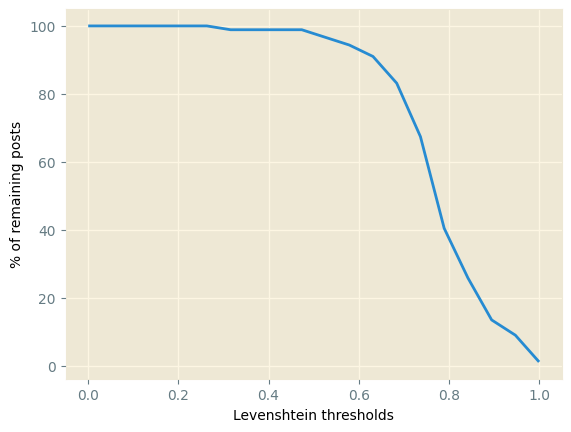

In [86]:
import matplotlib.pyplot as plt

fig = plt.figure()
with plt.style.context('Solarize_Light2'):
    plt.plot(x, y)
    plt.xlabel('Levenshtein thresholds')
    plt.ylabel('% of remaining posts')

In [4]:
def get_duplicates(
    corpus: list, 
    limit: float, 
    method: callable
    ):
    originals = []
    copies = []
    t = [utilities.clean_hashtag(s).strip() for s in corpus]
    distance = method #initialisiation de levenshtein avec la distance normalisée.
    i = 0
    r = len(t)
    while(i<r):
        r = len(t)
        j=i+1
        while(j<r):
            if(distance(t[i],t[j]) <= limit ): # Si la distance entre les deux élemens de la liste inf à seuil
                originals.append(t[i])
                copies.append([t[j]])
                break
            j+=1
        i+=1
    return pd.DataFrame({'originals' : originals , 'copies' : copies})

In [31]:
dist = textdistance.levenshtein.normalized_distance
originlas_copies = get_duplicates(corpus['text'].sample(n= 50, random_state = 42).tolist(),0.5,dist)

In [30]:
originlas_copies

,originals,copies
0,Went to see sweeneytoddbway with joshgroban. I...,[Just a chanel.beauty lover over here 🥚\n\n———...
1,Chanel blue sandals for the summer💙,[She judges it fr]
2,With uarmyhope 🤍🫶🏻\n #민지 \n——\n[230414] newje...,[CHANEL チャネル\n.\n.\n.\n#写真好きな人と繋がりたい \n#いいね返し ...
3,S O P H I E L E G E N D R E\n\nPhotography s...,[Get summer ready with us! Shop with us at CHA...
4,She judges it fr,[Images of filming a commercial with . 🎥]
5,"""🎈Welcome to my shop We sell shoes, bags, belt...",[Get summer ready with us! Shop with us at CHA...
6,Get summer ready with us! Shop with us at CHAN...,"[got the iconic fall 1993 dress, originally w..."
7,PRADA Logo Moccasins Size 36 available in our ...,[drinking champagne made of an angels tears an...
8,"got the iconic fall 1993 dress, originally wo...",[drinking champagne made of an angels tears an...
9,drinking champagne made of an angels tears and...,[Us forever sister 👯‍♀️ Rolls Royce Ghost 🤍]


In [7]:
def get_duplicates_per_thresholds():
    list_duplicates_per_thresholds = []
    list_thresholds = np.linspace(0.4,1,13)
    dist = textdistance.levenshtein.normalized_distance
    for thresholds in list_thresholds:
        list_duplicates_per_thresholds.append(get_duplicates(corpus['text'].sample(n= 50, random_state = 10).tolist(),thresholds,dist))
    return pd.DataFrame({'threshold' : list_thresholds , 'duplicates' : list_duplicates_per_thresholds})

In [9]:
df_dup_per_thesh = get_duplicates_per_thresholds()

In [11]:
df_dup_per_thesh

,threshold,duplicates
0,0.40,ori...
1,0.45,ori...
2,0.50,ori...
3,0.55,ori...
4,0.60,ori...
5,0.65,ori...
6,0.70,or...
7,0.75,or...
8,0.80,or...
9,0.85,or...


In [35]:
df_dup_per_thesh['duplicates'][4]

,originals,copies
0,"If you need my products, please add my whatsap...","[If you need my products, please add my whatsa..."
1,"Wholesale (shoes, clothes, hats, belts, etc.) ...","[Wholesale (shoes, clothes, hats, belts, etc.)..."
2,We are mainly engaged in various brands of sho...,[We are mainly engaged in various brands of sh...
3,,[]
4,"Hello friend, there are many products you need...","[Hello friend, there are many products you nee..."


### Optimisation paramètres de l'arbre de décision

In [70]:
chanel_junk_valid_new = pd.read_excel('C:/Users/a.tekiouk/Sujet_2/Sujet_2/DATA/chanel_junk_valid_new.xlsx')
chanel_junk_valid_new = chanel_junk_valid_new[['text','is_junk']].dropna()
chanel_junk_valid_new['has_URL'] = utilities.get_presence_of_URL(corpus= chanel_junk_valid_new['text'], nlp= nlp  )
chanel_junk_valid_new['has_phone_number'] = utilities.get_presence_of_phone_numbers(corpus= chanel_junk_valid_new['text'], nlp= nlp  )
chanel_junk_valid_new['has_currency_symbol'] = utilities.get_presence_of_currency_symbol(corpus= chanel_junk_valid_new['text'], nlp= nlp  )
chanel_junk_valid_new['word_ratio'] = utilities.get_word_ratio(corpus= chanel_junk_valid_new['text'], nlp= nlp  )
chanel_junk_valid_new['caps_ratio'] = utilities.get_caps_ratio(corpus= chanel_junk_valid_new['text'], nlp= nlp)
chanel_junk_valid_new['norm_punct'] = utilities.get_normalized_nb_punct(corpus= chanel_junk_valid_new['text'], nlp= nlp  )
chanel_junk_valid_new = chanel_junk_valid_new.join(utilities.create_dummies(corpus= chanel_junk_valid_new['text'],y = chanel_junk_valid_new['is_junk'], element= 'emoji',nlp = nlp, top= 3))
chanel_all_features = chanel_junk_valid_new.join(utilities.create_dummies(corpus= chanel_junk_valid_new['text'],y = chanel_junk_valid_new['is_junk'], element= 'hashtag', nlp = nlp, top= 3))
train,test = utilities.train_test(data = chanel_all_features.dropna().drop('text',axis=1), y = 'is_junk', f_y0= 0.7, f_y1= 0.7)
X_train = train.drop('is_junk',axis=1)
y_train = train['is_junk']
X_test = test.drop('is_junk',axis=1)
y_test = test['is_junk']


In [9]:
def optimize_ccp_alpha(X_train,X_test,y_train,y_test):    
    list_ccp_alpha = np.linspace(0.01,0.040,31)
    list_auc = []
    for ccp in list_ccp_alpha:
        tree = DecisionTreeClassifier(criterion = 'entropy', max_depth=8, ccp_alpha = ccp, min_samples_leaf = 5)
        tree.fit(X_train,y_train)
        y_pred = tree.predict(X_test)
        fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
        list_auc.append(metrics.auc(fpr, tpr))
    return list_ccp_alpha,list_auc 

Arbre 1 : 

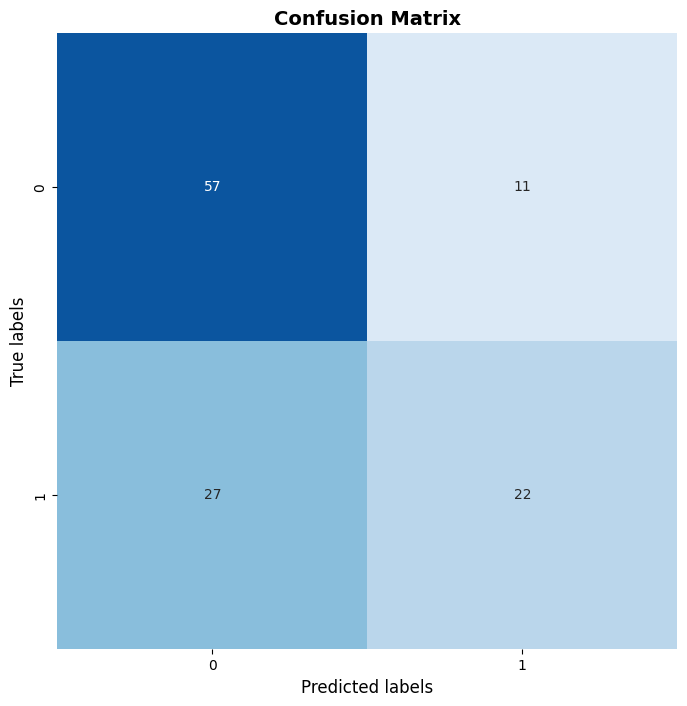

AUC : 0.6436074429771909
Accuracy score : 0.6752136752136753


In [68]:
tree1 = DecisionTreeClassifier(criterion = 'gini')
tree1.fit(X_train,y_train)
y_pred = tree1.predict(X_test)
utilities.plot_confusion_matrix(y_true = y_test, y_pred = y_pred)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
print(f"AUC : {metrics.auc(fpr, tpr)}")
print(f"Accuracy score : {metrics.accuracy_score(y_test, y_pred)}")

Arbre 2

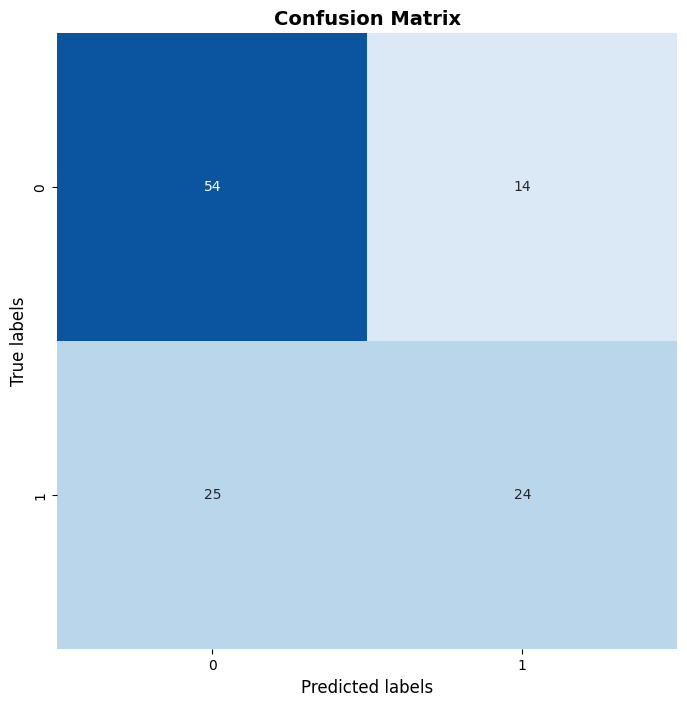

AUC : 0.6419567827130853
Accuracy score : 0.6666666666666666


In [61]:
tree2 = DecisionTreeClassifier(criterion = 'entropy')
tree2.fit(X_train,y_train)
y_pred = tree2.predict(X_test)
utilities.plot_confusion_matrix(y_true = y_test, y_pred = y_pred)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
print(f"AUC : {metrics.auc(fpr, tpr)}")
print(f"Accuracy score : {metrics.accuracy_score(y_test, y_pred)}")

Arbre 3

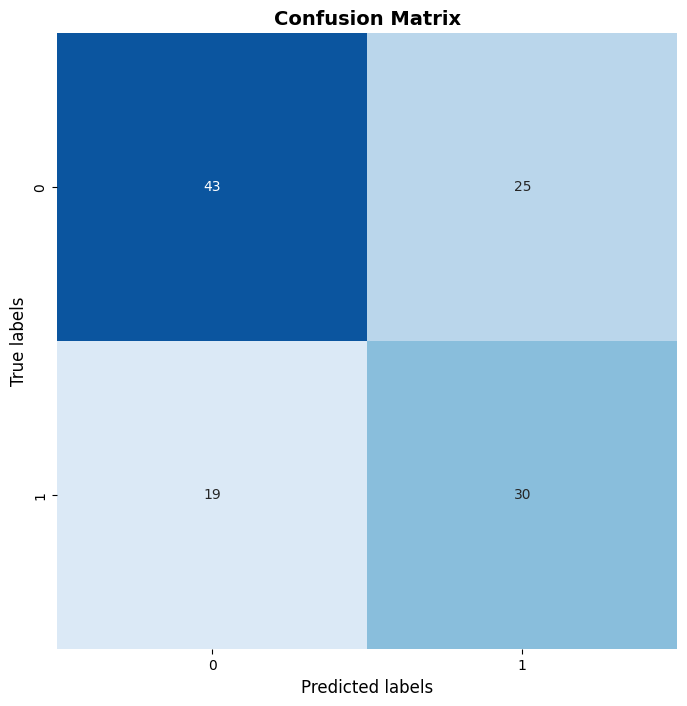

AUC : 0.6222989195678271
Accuracy score : 0.6239316239316239


In [67]:
tree3 = DecisionTreeClassifier(criterion = 'entropy',class_weight = "balanced")
tree3.fit(X_train,y_train)
y_pred = tree3.predict(X_test)
utilities.plot_confusion_matrix(y_true = y_test, y_pred = y_pred)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
print(f"AUC : {metrics.auc(fpr, tpr)}")
print(f"Accuracy score : {metrics.accuracy_score(y_test, y_pred)}")

Arbre 4

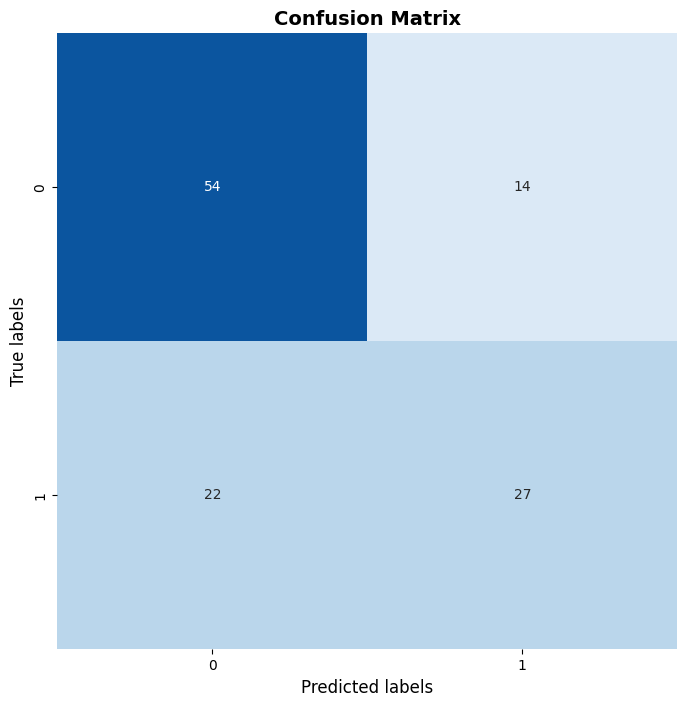

AUC : 0.6725690276110444
Accuracy score : 0.6923076923076923


In [37]:
tree4 = DecisionTreeClassifier(criterion = 'entropy', max_depth=10)
tree4.fit(X_train,y_train)
y_pred = tree4.predict(X_test)
utilities.plot_confusion_matrix(y_true = y_test, y_pred = y_pred)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
print(f"AUC : {metrics.auc(fpr, tpr)}")
print(f"Accuracy score : {metrics.accuracy_score(y_test, y_pred)}")

Arbre 5

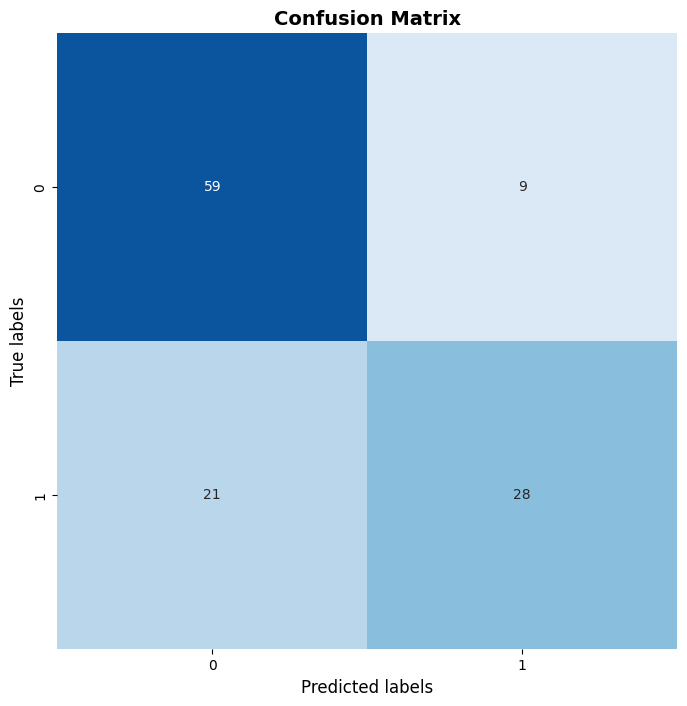

AUC : 0.7195378151260504
Accuracy score : 0.7435897435897436


In [90]:
tree5 = DecisionTreeClassifier(criterion = 'entropy', max_depth = 8, ccp_alpha = 0.011, min_samples_leaf = 5)
tree5.fit(X_train,y_train)
y_pred = tree5.predict(X_test)
utilities.plot_confusion_matrix(y_true = y_test, y_pred = y_pred)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
print(f"AUC : {metrics.auc(fpr, tpr)}")
print(f"Accuracy score : {metrics.accuracy_score(y_test, y_pred)}")

[Text(0.75, 0.9285714285714286, 'has_phone_number <= 0.5\nentropy = 0.98\nsamples = 271\nvalue = [158, 113]\nclass = 1'),
 Text(0.625, 0.7857142857142857, 'word_ratio <= 0.978\nentropy = 0.934\nsamples = 243\nvalue = [158, 85]\nclass = 1'),
 Text(0.5, 0.6428571428571429, 'entropy = 0.797\nsamples = 29\nvalue = [7, 22]\nclass = 0'),
 Text(0.75, 0.6428571428571429, '❤ <= 0.5\nentropy = 0.874\nsamples = 214\nvalue = [151, 63]\nclass = 1'),
 Text(0.625, 0.5, 'norm_punct <= 0.339\nentropy = 0.846\nsamples = 205\nvalue = [149, 56]\nclass = 1'),
 Text(0.5, 0.35714285714285715, 'norm_punct <= 0.149\nentropy = 0.867\nsamples = 194\nvalue = [138, 56]\nclass = 1'),
 Text(0.25, 0.21428571428571427, 'norm_punct <= 0.012\nentropy = 0.772\nsamples = 128\nvalue = [99, 29]\nclass = 1'),
 Text(0.125, 0.07142857142857142, 'entropy = 0.953\nsamples = 51\nvalue = [32, 19]\nclass = 1'),
 Text(0.375, 0.07142857142857142, 'entropy = 0.557\nsamples = 77\nvalue = [67, 10]\nclass = 1'),
 Text(0.75, 0.21428571428

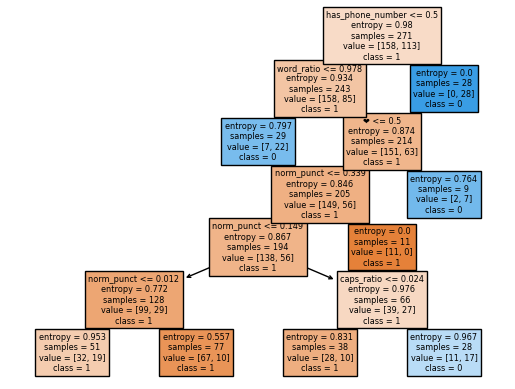

In [91]:
sklearn.tree.plot_tree(tree5,feature_names = X_train.columns, class_names = ['1','0'], filled = True)

In [23]:
ccp,auc = optimize_ccp_alpha(X_train,X_test,y_train,y_test)

In [25]:
ccp,auc

(array([0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017, 0.018,
        0.019, 0.02 , 0.021, 0.022, 0.023, 0.024, 0.025, 0.026, 0.027,
        0.028, 0.029, 0.03 , 0.031, 0.032, 0.033, 0.034, 0.035, 0.036,
        0.037, 0.038, 0.039, 0.04 ]),
 [0.7648559423769509,
  0.7648559423769509,
  0.7648559423769509,
  0.7648559423769509,
  0.7648559423769509,
  0.7518007202881152,
  0.7518007202881152,
  0.7518007202881152,
  0.7518007202881152,
  0.7518007202881152,
  0.7518007202881152,
  0.7518007202881152,
  0.7518007202881152,
  0.7518007202881152,
  0.7518007202881152,
  0.7518007202881152,
  0.7228391356542618,
  0.7228391356542618,
  0.7228391356542618,
  0.7228391356542618,
  0.7228391356542618,
  0.7228391356542618,
  0.7228391356542618,
  0.7228391356542618,
  0.7228391356542618,
  0.7228391356542618,
  0.7228391356542618,
  0.7228391356542618,
  0.7228391356542618,
  0.7228391356542618,
  0.7228391356542618])

In [68]:
list_parameters

[(5, 0.01, 1),
 (5, 0.01, 2),
 (5, 0.01, 3),
 (5, 0.01, 4),
 (5, 0.01, 5),
 (5, 0.01, 6),
 (5, 0.01, 7),
 (5, 0.01, 8),
 (5, 0.01, 9),
 (5, 0.01, 10),
 (5, 0.01, 11),
 (5, 0.01, 12),
 (5, 0.01, 13),
 (5, 0.01, 14),
 (5, 0.01, 15),
 (5, 0.011, 1),
 (5, 0.011, 2),
 (5, 0.011, 3),
 (5, 0.011, 4),
 (5, 0.011, 5),
 (5, 0.011, 6),
 (5, 0.011, 7),
 (5, 0.011, 8),
 (5, 0.011, 9),
 (5, 0.011, 10),
 (5, 0.011, 11),
 (5, 0.011, 12),
 (5, 0.011, 13),
 (5, 0.011, 14),
 (5, 0.011, 15),
 (5, 0.012, 1),
 (5, 0.012, 2),
 (5, 0.012, 3),
 (5, 0.012, 4),
 (5, 0.012, 5),
 (5, 0.012, 6),
 (5, 0.012, 7),
 (5, 0.012, 8),
 (5, 0.012, 9),
 (5, 0.012, 10),
 (5, 0.012, 11),
 (5, 0.012, 12),
 (5, 0.012, 13),
 (5, 0.012, 14),
 (5, 0.012, 15),
 (5, 0.013000000000000001, 1),
 (5, 0.013000000000000001, 2),
 (5, 0.013000000000000001, 3),
 (5, 0.013000000000000001, 4),
 (5, 0.013000000000000001, 5),
 (5, 0.013000000000000001, 6),
 (5, 0.013000000000000001, 7),
 (5, 0.013000000000000001, 8),
 (5, 0.013000000000000001, 9)

In [24]:
ccp[auc==max(auc)]

array([0.01 , 0.011, 0.012, 0.013, 0.014])

### Combinaison des trois paramètres 

In [56]:
import itertools
def optimize_parameters_decision_tree(X_train,X_test,y_train,y_test): 
    list_max_depth = np.linspace(5,20,16, dtype= int)
    list_ccp_alpha = np.linspace(0.01,0.040,31)
    list_min_sample_leaf = np.linspace(1,15,15,dtype= int)
    param = [list_max_depth,list_ccp_alpha,list_min_sample_leaf]
    list_parameters = list(itertools.product(*param))
    list_auc=[]
    for parameters in list_parameters:
        tree = DecisionTreeClassifier(criterion = 'entropy', max_depth=parameters[0], ccp_alpha = parameters[1], min_samples_leaf = parameters[2])
        tree.fit(X_train,y_train)
        y_pred = tree.predict(X_test)
        fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
        list_auc.append(metrics.auc(fpr, tpr))
    return list_parameters,list_auc